In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
import libpysal
from spreg import OLS, ML_Lag, ML_Error, GM_Lag 
from esda.moran import Moran
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

import folium
from folium.plugins import MarkerCluster
from IPython.display import display, IFrame

In [2]:
neighbourhoods = gpd.read_file("data/neighbourhoods.geojson")
full_listings = pd.read_csv("data/listings.csv.gz", compression='gzip')

neighbourhoods

,neighbourhood,neighbourhood_group,geometry
0,Alcamo,None,"MULTIPOLYGON (((12.97904 38.03825, 12.98352 38..."
1,Buseto Palizzolo,None,"MULTIPOLYGON (((12.714 38.04069, 12.72156 38.0..."
2,Petrosino,None,"MULTIPOLYGON (((12.60087 37.72004, 12.60465 37..."
3,Calatafimi-Segesta,None,"MULTIPOLYGON (((12.92246 37.98607, 12.92292 37..."
4,Campobello di Mazara,None,"MULTIPOLYGON (((12.75116 37.65926, 12.756 37.6..."
...,...,...,...
385,Rosolini,None,"MULTIPOLYGON (((14.87385 36.86987, 14.87756 36..."
386,Portopalo di Capo Passero,None,"MULTIPOLYGON (((15.13485 36.69094, 15.14008 36..."
387,Priolo Gargallo,None,"MULTIPOLYGON (((15.20137 37.17807, 15.20025 37..."
388,Siracusa,None,"MULTIPOLYGON (((15.26576 37.11421, 15.25912 37..."


<Axes: >

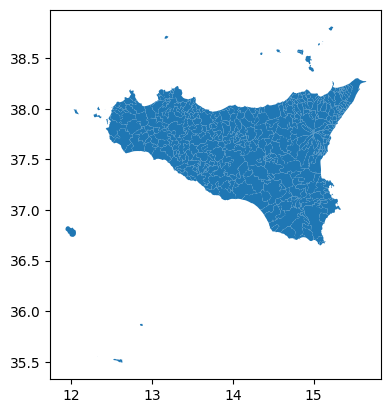

In [3]:
neighbourhoods.plot()

In [4]:
neighbourhoods.type

0      MultiPolygon
1      MultiPolygon
2      MultiPolygon
3      MultiPolygon
4      MultiPolygon
           ...     
385    MultiPolygon
386    MultiPolygon
387    MultiPolygon
388    MultiPolygon
389    MultiPolygon
Length: 390, dtype: str

In [5]:
print(full_listings.shape)
full_listings.columns

(57531, 79)


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [3]:
# if not empty there is a mismatch in neighbourhood names
set(full_listings["neighbourhood_cleansed"]) - set(neighbourhoods["neighbourhood"])

set()

In [7]:
#gdf = neighbourhoods.merge(full_listings, left_on="neighbourhood", right_on="neighbourhood_cleansed")

In [4]:

# spatial join is more trustworthy
full_listings["geometry"] = gpd.points_from_xy(
full_listings.longitude,
full_listings.latitude
)


listings_gdf = gpd.GeoDataFrame(
full_listings,
geometry="geometry",
crs=neighbourhoods.crs
)


gdf = gpd.sjoin(
listings_gdf,
neighbourhoods,
how="left",
predicate="within"
)

print(gdf.shape)
print(gdf.columns)
gdf

(57531, 83)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_left',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nig

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,index_right,neighbourhood_right,neighbourhood_group
0,7011,https://www.airbnb.com/rooms/7011,20250929042425,2025-09-29,city scrape,SEASIDE - Historic Antique Residence,WINEYARD WITH COLOURS OF THE SEASIDE.<br /><br...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,16888,...,t,10,10,0,0,0.16,POINT (12.47949 37.83969),13.0,Marsala,None
1,22948,https://www.airbnb.com/rooms/22948,20250929042425,2025-09-30,city scrape,BnB Room with Balcony near Valley of the Temples,Near the Central Station and the beginning of ...,"The neighborhood is in a residential area, cen...",https://a0.muscache.com/pictures/hosting/Hosti...,88837,...,t,3,0,3,0,2.67,POINT (13.58569 37.30949),214.0,Agrigento,None
2,35264,https://www.airbnb.com/rooms/35264,20250929042425,2025-09-29,city scrape,Etna-sea a panoramic villa,"Our country house, swathed in the greenery of ...","Contact with nature, relaxation, remarkable pa...",https://a0.muscache.com/pictures/7dc73c6a-7bee...,151644,...,f,5,5,0,0,0.89,POINT (15.15876 37.82461),339.0,Piedimonte Etneo,None
3,43992,https://www.airbnb.com/rooms/43992,20250929042425,2025-09-30,city scrape,Two steps from the sea,Very nice flat in front of the beach with a wo...,NaN,https://a0.muscache.com/pictures/9495798/e9cfb...,192525,...,f,2,2,0,0,0.53,POINT (12.53462 38.03442),8.0,Erice,None
4,43995,https://www.airbnb.com/rooms/43995,20250929042425,2025-09-30,city scrape,Villa Verdemare,Wonderful villa that can easily accommodate up...,NaN,https://a0.muscache.com/pictures/9498289/eef27...,192525,...,f,2,2,0,0,0.46,POINT (12.74028 38.16904),24.0,San Vito Lo Capo,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57526,1519677215501430225,https://www.airbnb.com/rooms/1519677215501430225,20250929042425,2025-09-29,city scrape,Lipari,The Room Lipari is located in Montallegro and ...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,593323434,...,t,192,142,50,0,NaN,POINT (13.34989 37.39167),239.0,Montallegro,None
57527,1519679190819906033,https://www.airbnb.com/rooms/1519679190819906033,20250929042425,2025-09-29,city scrape,Favignana,The Room Favignana is located in Montallegro a...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,593323434,...,t,192,142,50,0,NaN,POINT (13.34989 37.39167),239.0,Montallegro,None
57528,1519679883965038281,https://www.airbnb.com/rooms/1519679883965038281,20250929042425,2025-09-29,city scrape,Panarea,The Room Panarea in Montallegro is the perfect...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,593323434,...,t,192,142,50,0,NaN,POINT (13.34989 37.39167),239.0,Montallegro,None
57529,1519680436299846402,https://www.airbnb.com/rooms/1519680436299846402,20250929042425,2025-09-30,city scrape,Casa del limoneto di Corrado Fronte,The villa Casa del Limoneto di Corrado Fronte ...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,205435091,...,t,2,2,0,0,NaN,POINT (15.11076 36.85468),383.0,Noto,None


In [5]:
price_vars = [
"price",
"geometry",
"room_type",
"property_type",
"accommodates",
"bedrooms",
"number_of_reviews",
"review_scores_rating",
"host_is_superhost",
"neighbourhood_cleansed",
]


df_model = gdf[price_vars].dropna()
df_model.shape

(37158, 10)

<Axes: >

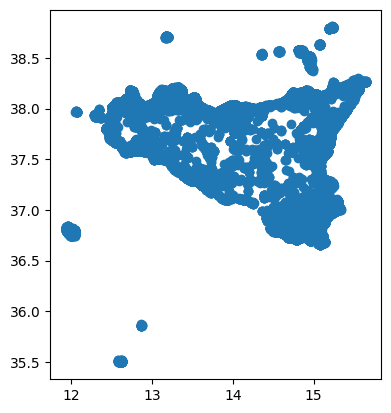

In [10]:
df_model.plot()

In [6]:
# cleaning 
full_listings["price"] = full_listings["price"].replace('[\$,]', '', regex=True).astype(float)

In [7]:
full_listings["log_price"] = np.log(full_listings["price"])

In [8]:
listings_gdf = gpd.GeoDataFrame(
    full_listings,
    geometry=gpd.points_from_xy(
    full_listings.longitude,
    full_listings.latitude
    ),
    crs="EPSG:4326"
)

listings_gdf.geometry.type.value_counts()

Point    57531
Name: count, dtype: int64

In [9]:
neighbourhoods = neighbourhoods.to_crs(listings_gdf.crs)

### VISUALIZATIONS

In [10]:
listings_gdf = listings_gdf[
np.isfinite(listings_gdf["log_price"])
].copy()

vmin = listings_gdf["log_price"].min()
vmax = listings_gdf["log_price"].max()


print(vmin, vmax)

2.0794415416798357 11.289781913656018


In [11]:
listings_gdf = gpd.GeoDataFrame(
    full_listings,
    geometry=gpd.points_from_xy(full_listings.longitude, full_listings.latitude),
    crs="EPSG:4326"
)

listings_gdf = listings_gdf[listings_gdf["price"].notna()]
listings_gdf["log_price"] = np.log(listings_gdf["price"])

In [64]:
import folium
from branca.colormap import linear
from folium import FeatureGroup, LayerControl

m = folium.Map(
    location=[
        listings_gdf.geometry.y.mean(),
        listings_gdf.geometry.x.mean()
    ],
    zoom_start=11,
    tiles="cartodbpositron"
)

colormap = linear.RdYlGn_09.scale(
    listings_gdf["log_price"].quantile(0.05),
    listings_gdf["log_price"].quantile(0.95)
)
colormap.colors = colormap.colors[::-1]
colormap.caption = "Log price (quantile-scaled)"
colormap.add_to(m)

In [65]:
def make_popup(row):
    return folium.Popup(
        f"""
        <b>Name:</b> {row['name']}<br>
        <b>Price:</b> €{row['price']}<br>
        <b>Room type:</b> {row['room_type']}<br>
        <b>Number of reviews:</b> {row['number_of_reviews']}<br>
        <b>Average rating:</b> {row['review_scores_rating']}<br>
        <b>Last review:</b> {row['last_review']}<br>
        <b>Minimum nights:</b> {row['minimum_nights']}
        """,
        max_width=250
    )

In [66]:
all_layer = folium.FeatureGroup(
    name="All cities",
    show=True   # 👈 visible by default
)

for _, row in listings_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        fill=True,
        fill_opacity=0.45,
        opacity=0,
        color=None,
        fill_color=colormap(row["log_price"]),
        popup=make_popup(row)
    ).add_to(all_layer)

all_layer.add_to(m)

for city, df_city in listings_gdf.groupby("neighbourhood_cleansed"):

    # performance safeguard
    if len(df_city) > 6000:
        df_city = df_city.sample(6000, random_state=42)

    city_layer = folium.FeatureGroup(
        name=city,
        show=False   # 👈 hidden initially
    )

    for _, row in df_city.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            fill=True,
            fill_opacity=0.45,
            opacity=0,
            color=None,
            fill_color=colormap(row["log_price"]),
            popup=make_popup(row)
        ).add_to(city_layer)

    city_layer.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

In [57]:
for city, df_city in listings_gdf.groupby("neighbourhood_cleansed"):
    
    # ⚠️ performance safety
    if len(df_city) > 6000:
        df_city = df_city.sample(6000, random_state=42)

    city_layer = folium.FeatureGroup(
        name=city,
        show=False
    )

    for _, row in df_city.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,                    # BIGGER markers
            fill=True,
            fill_opacity=0.45,
            opacity=0,
            color=None,
            fill_color=colormap(row["log_price"]),
            popup=make_popup(row)
        ).add_to(city_layer)

    city_layer.add_to(m)

In [58]:
folium.LayerControl(
    collapsed=False
).add_to(m)

In [59]:
entire_layer = FeatureGroup(name="Entire home / apartment", show=True)
private_layer = FeatureGroup(name="Private room", show=False)
shared_layer = FeatureGroup(name="Shared room", show=False)

In [61]:
for _, row in listings_gdf.iterrows():

    room_type = row["room_type"]

    if room_type == "Entire home/apt":
        layer = entire_layer
    elif room_type == "Private room":
        layer = private_layer
    elif room_type == "Shared room":
        layer = shared_layer
    else:
        continue

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        fill=True,
        fill_opacity=0.45,
        opacity=0,
        color=None,
        fill_color=colormap(row["log_price"])
    ).add_to(layer)

In [62]:
entire_layer.add_to(m)
private_layer.add_to(m)
shared_layer.add_to(m)

LayerControl(collapsed=False).add_to(m)

In [67]:
m.save("airbnb_prices_map.html")
#IFrame("airbnb_prices_map.html", width="10%", height=100)

In [68]:
import pydeck as pdk
import pandas as pd
import numpy as np

df = listings_gdf.copy()

# ensure numeric
df["price"] = df["price"].astype(float)
df["log_price"] = np.log(df["price"])

# scale price for color (0–255)
p_min, p_max = df["log_price"].quantile([0.05, 0.95])
df["price_scaled"] = (
    255 * (df["log_price"] - p_min) / (p_max - p_min)
).clip(0, 255)

In [69]:
scatter_layer = pdk.Layer(
    "ScatterplotLayer",
    data=df,
    get_position=["longitude", "latitude"],
    get_radius=80,               # controls visual density
    radius_units="meters",
    get_fill_color="[price_scaled, 255 - price_scaled, 0]",
    pickable=True,
    opacity=0.6
)

In [70]:
tooltip = {
    "html": """
    <b>Price:</b> €{price} <br>
    <b>Room type:</b> {room_type} <br>
    <b>Reviews:</b> {number_of_reviews} <br>
    <b>Avg rating:</b> {review_scores_rating} <br>
    <b>Last review:</b> {last_review}
    """,
    "style": {"backgroundColor": "white", "color": "black"}
}

In [71]:
view_state = pdk.ViewState(
    latitude=df.latitude.mean(),
    longitude=df.longitude.mean(),
    zoom=11,
    pitch=0
)

In [72]:
deck = pdk.Deck(
    layers=[scatter_layer],
    initial_view_state=view_state,
    tooltip=tooltip,
    map_style="mapbox://styles/mapbox/light-v9"
)

In [73]:
deck.to_html(
    "airbnb_prices_map.html",
    open_browser=False,
    notebook_display=False
)

In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
import palettable

# --- STEP 1: DATA PREPARATION ---
# Create the GeoDataFrame
listings_gdf = gpd.GeoDataFrame(
    full_listings,
    geometry=gpd.points_from_xy(full_listings.longitude, full_listings.latitude),
    crs="EPSG:4326"
)

# Clean data: Remove rows with no price or no geometry
listings_gdf = listings_gdf.dropna(subset=['price', 'geometry']).copy()

# Calculate log price for better color distribution
listings_gdf["log_price"] = np.log(listings_gdf["price"])
listings_gdf = listings_gdf[np.isfinite(listings_gdf["log_price"])].copy()

# Filter specific columns for the tooltip (reduces memory & cleans up UI)
tooltip_cols = [
    'name', 'price', 'room_type', 'number_of_reviews', 
    'review_scores_rating', 'last_review', 'minimum_nights'
]
# Ensure we keep geometry and the column used for coloring
data_for_map = listings_gdf[tooltip_cols + ['geometry', 'log_price']].copy()

# --- STEP 2: STYLING & COLORING ---
# Scale log_price between 0 and 1 for the colormap (using 5th/95th percentiles to avoid outliers)
v_min = data_for_map["log_price"].quantile(0.05)
v_max = data_for_map["log_price"].quantile(0.95)
norm_price = (data_for_map["log_price"] - v_min) / (v_max - v_min)
norm_price = norm_price.clip(0, 1)

# Apply the RdYlGn (Red-Yellow-Green) colormap
# We use _r to reverse it so Green = Expensive (or remove _r for Red = Expensive)
colors = apply_continuous_cmap(
    norm_price, 
    palettable.colorbrewer.diverging.RdYlGn_9_r, 
    alpha=0.6
)

# --- STEP 3: CREATE THE INTERACTIVE LAYER ---
layer = ScatterplotLayer.from_geopandas(
    gdf=data_for_map,
    get_fill_color=colors,
    get_radius=15,           # Radius in meters
    radius_min_pixels=2,     # Points remain visible when zooming out
    pickable=True,           # This enables the interactive tooltips
    auto_highlight=True      # Subtle glow effect on hover
)

# --- STEP 4: RENDER THE MAP ---
view_state = {
    "longitude": data_for_map.geometry.x.mean(),
    "latitude": data_for_map.geometry.y.mean(),
    "zoom": 10,
    "pitch": 0,
}

m = Map(layers=[layer], view_state=view_state).to_html("airbnb_prices_map.html")

# Display the map (works in Jupyter, VS Code, or Colab)


In [19]:
import streamlit as st
import pandas as pd
import numpy as np
import geopandas as gpd
from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
import palettable

# 1. Page Configuration
st.set_page_config(layout="wide", page_title="Sicily Airbnb Analysis")

# --- DATA LOADING ---
@st.cache_data
def process_data():
    # If full_listings exists in your workspace, use it. 
    # Otherwise, this block creates a small sample so the code doesn't crash.
    try:
        df = full_listings.copy()
    except NameError:
        # DUMMY DATA FOR TESTING (Remove this once your full_listings is ready)
        data = {
            'name': ['Listing 1', 'Listing 2', 'Listing 3'],
            'price': [100, 200, 300],
            'latitude': [38.1157, 37.5025, 38.0176],
            'longitude': [13.3615, 15.0873, 12.5152],
            'neighbourhood_cleansed': ['Palermo', 'Catania', 'Trapani'],
            'room_type': ['Entire home', 'Private room', 'Entire home'],
            'number_of_reviews': [10, 5, 20],
            'review_scores_rating': [4.5, 4.0, 5.0],
            'last_review': ['2023-01-01', '2023-01-02', '2023-01-03'],
            'minimum_nights': [2, 1, 3]
        }
        df = pd.DataFrame(data)

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )
    
    # Cleaning
    gdf = gdf.dropna(subset=['price', 'geometry']).copy()
    gdf["log_price"] = np.log(gdf["price"].replace(0, 1)) # Avoid log(0)
    return gdf

# Initialize Data
listings_gdf = process_data()

# --- SIDEBAR FILTERS ---
st.sidebar.header("Filter Options")

# Filter by Neighborhood
neighborhoods = sorted(listings_gdf['neighbourhood_cleansed'].unique())
selected_neigh = st.sidebar.multiselect("Select Cities", neighborhoods, default=neighborhoods)

# Filter by Price Range
min_p, max_p = int(listings_gdf.price.min()), int(listings_gdf.price.max())
price_range = st.sidebar.slider("Price Range (€)", min_p, max_p + 100, (min_p, max_p + 100))

# Apply filtering
filtered_gdf = listings_gdf[
    (listings_gdf['neighbourhood_cleansed'].isin(selected_neigh)) &
    (listings_gdf['price'].between(price_range[0], price_range[1]))
].copy()

# --- MAP VISUALIZATION ---
st.title("Sicily Airbnb - Geospatial Project")

if not filtered_gdf.empty:
    # 1. Color logic
    v_min = filtered_gdf["log_price"].min()
    v_max = filtered_gdf["log_price"].max()
    
    # Avoid division by zero if all prices are the same
    if v_max == v_min:
        norm_price = np.zeros(len(filtered_gdf))
    else:
        norm_price = (filtered_gdf["log_price"] - v_min) / (v_max - v_min)
    
    norm_price = np.clip(norm_price, 0, 1)
    
    colors = apply_continuous_cmap(
        norm_price, 
        palettable.colorbrewer.diverging.RdYlGn_9_r, 
        alpha=0.7
    )

    # 2. Lonboard Layer
    # Use only necessary columns for the tooltip
    layer = ScatterplotLayer.from_geopandas(
        gdf=filtered_gdf,
        get_fill_color=colors,
        get_radius=15,
        radius_min_pixels=3,
        pickable=True,
        auto_highlight=True
    )

    # 3. View State (Center of Sicily or data)
    view_state = {
        "longitude": filtered_gdf.geometry.x.mean(),
        "latitude": filtered_gdf.geometry.y.mean(),
        "zoom": 7,
        "pitch": 0,
        "bearing": 0,
    }

    # 4. Create the Map Object
    m = Map(layers=[layer], view_state=view_state).to_html("filtered_airbnb_map.html")

    # 5. Metrics Display
    m1, m2, m3 = st.columns(3)
    m1.metric("Listings", len(filtered_gdf))
    m2.metric("Avg Price", f"€{filtered_gdf.price.mean():.2f}")
    m3.metric("Max Price", f"€{filtered_gdf.price.max():.2f}")

    # 6. RENDER (The fix for the NoneType error)
    # Check if m is valid and use the streamlit-compatible call
    try:
        # In modern Lonboard/Streamlit, you can often just call the object
        # but the safest way to render the HTML component is:
        map_html = m._repr_html_()
        if map_html:
            st.components.v1.html(map_html, height=600)
        else:
            st.error("Map representation returned empty.")
    except Exception as e:
        st.error(f"Error rendering map: {e}")
        # Fallback: some versions of Lonboard work directly with st.map if using simple data
        # but for ScatterplotLayer, we need the HTML.
else:
    st.warning("No listings found for these filters. Please adjust the sidebar.")

2026-01-29 21:03:22.027 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 21:03:22.027 No runtime found, using MemoryCacheStorageManager
2026-01-29 21:03:22.027 No runtime found, using MemoryCacheStorageManager
2026-01-29 21:03:22.027 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 21:03:23.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 21:03:23.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 21:03:23.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 21:03:23.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 21:03:23.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignor

In [21]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, Fullscreen
from branca.colormap import linear

# --- 1. DATA PREPARATION ---
# Clean and prepare the main GeoDataFrame
listings_gdf = gpd.GeoDataFrame(
    full_listings,
    geometry=gpd.points_from_xy(full_listings.longitude, full_listings.latitude),
    crs="EPSG:4326"
)

# Basic cleaning
listings_gdf = listings_gdf.dropna(subset=['price', 'geometry']).copy()
listings_gdf["log_price"] = np.log(listings_gdf["price"].replace(0, 1))

# Define the popup helper
def make_popup(row):
    return folium.Popup(f"""
        <div style="font-family: sans-serif; font-size: 12px; width: 200px;">
            <b>Name:</b> {row['name']}<br>
            <b>Price:</b> €{row['price']}<br>
            <b>Room:</b> {row['room_type']}<br>
            <b>Rating:</b> {row.get('review_scores_rating', 'N/A')}⭐
        </div>
    """, max_width=250)

# --- 2. MAP A: ALL SICILY (Overview) ---
# Strategy: Use FastMarkerCluster to keep the HTML file size small
m_sicily = folium.Map(
    location=[37.6, 14.0], 
    zoom_start=8, 
    tiles="cartodbpositron"
)

# Convert coordinates to list for the cluster
callback = ('function (row) {'
            'var marker = L.marker(new L.LatLng(row[0], row[1]));'
            'return marker;'
            '}')

# This allows 10,000+ points to load instantly as clusters
FastMarkerCluster(
    data=list(zip(listings_gdf.geometry.y, listings_gdf.geometry.x)),
    callback=callback,
    name="All Sicily Listings"
).add_to(m_sicily)

Fullscreen().add_to(m_sicily)
m_sicily.save("map_sicily_overview.html")

# --- 3. MAP B: PALERMO DEEP DIVE (Detailed) ---
# Strategy: Focus on one city to keep the point count low and interactivity high
palermo_gdf = listings_gdf[listings_gdf['neighbourhood_cleansed'] == 'Palermo'].copy()

m_palermo = folium.Map(
    location=[38.1157, 13.3615], 
    zoom_start=13, 
    tiles="cartodbpositron"
)

# Create a color scale for price
colormap = linear.RdYlGn_09.scale(
    palermo_gdf["log_price"].quantile(0.05),
    palermo_gdf["log_price"].quantile(0.95)
)
colormap.caption = "Price Scale (Log)"
colormap.add_to(m_palermo)

# Group listings by Room Type for Layer Control
for room_type, df_room in palermo_gdf.groupby("room_type"):
    feature_group = folium.FeatureGroup(name=room_type)
    
    for _, row in df_room.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color=None,
            fill=True,
            fill_color=colormap(row["log_price"]),
            fill_opacity=0.45,
            popup=make_popup(row),
            tooltip=row['name'][:30] # Simple hover tooltip
        ).add_to(feature_group)
    
    feature_group.add_to(m_palermo)

folium.LayerControl().add_to(m_palermo)
Fullscreen().add_to(m_palermo)
m_palermo.save("map_palermo_detailed.html")

print("Maps generated: map_sicily_overview.html and map_palermo_detailed.html")

Maps generated: map_sicily_overview.html and map_palermo_detailed.html
